# Import Drive Directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Bangkit/Projects/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Packages

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from math import isnan

# Import Tensorflow

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


# Read Data Input

In [ ]:
df = pd.read_csv(root_path + 'mobilbekas.csv')

In [ ]:
df.shape

(14657, 16)

In [ ]:
df.head()

,Harga,Lokasi,Penjual,Merek,Model,Varian,Tahun,Jarak tempuh,Tipe bahan bakar,Warna,Transmisi,Tipe bodi,Kapasitas mesin,Tipe Penjual,Sistem Penggerak,Nama Bursa Mobil
0,155000792,"Ngaliyan, Semarang Kota, Jawa Tengah",Tegar Ranisdya,BMW,Serie 3,320i Business Edition,2006,85.000-90.000 km,Bensin,Hitam,Automatic,Sedan,>1.500 - 2.000 cc,Individu,NaN,NaN
1,56000000,"Medan Johor, Medan Kota, Sumatra Utara",Anda Syahwilhanto,Hyundai,Getz,Lain-lain,2005,0-5.000 km,Bensin,Biru,Manual,Hatchback,>1.000 - 1.500 cc,Individu,Front Wheel Drive (FWD),NaN
2,120000000,"Ilir Timur I, Palembang Kota, Sumatra Selatan",alvianistm,Isuzu,Grand touring,Lain-lain,2004,10.000-15.000 km,Diesel,Silver,Manual,NaN,NaN,Individu,NaN,NaN
3,169000000,"Balerejo, Madiun Kab., Jawa Timur",PUSAT MOBIL BEKAS SIDOARJO,Isuzu,Grand touring,Lain-lain,2010,100.000-105.000 km,Diesel,Coklat,Manual,Minibus,>2.000 - 3.000 cc,Diler,NaN,NaN
4,120000000,"Kemayoran, Jakarta Pusat, Jakarta D.K.I.",Kristian,Proton,Lain-lain,Lain-lain,2010,75.000-80.000 km,Bensin,Oranye,Manual,Pick-up,>1.500 - 2.000 cc,NaN,Rear Wheel Drive (RWD),Pasar Mobil Kemayoran


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14657 entries, 0 to 14656
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Harga             14657 non-null  int64 
 1   Lokasi            14657 non-null  object
 2   Penjual           14657 non-null  object
 3   Merek             14657 non-null  object
 4   Model             14657 non-null  object
 5   Varian            13941 non-null  object
 6   Tahun             14657 non-null  object
 7   Jarak tempuh      14657 non-null  object
 8   Tipe bahan bakar  14657 non-null  object
 9   Warna             14657 non-null  object
 10  Transmisi         14657 non-null  object
 11  Tipe bodi         12491 non-null  object
 12  Kapasitas mesin   12859 non-null  object
 13  Tipe Penjual      12175 non-null  object
 14  Sistem Penggerak  11488 non-null  object
 15  Nama Bursa Mobil  2547 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.8+ MB


In [ ]:
# Selecting features
df1 = df.loc[:, ('Harga', 'Merek', 'Model', 'Varian', 'Tahun', 'Jarak tempuh')]

Features Selection Consideration:

1.   **Harga** - label
3. **Merek**, **Model**, **Varian** - three of the main factors
4. **Tahun** - the older, the lower the price
5. **Jarak tempuh** - the higher, the lower the price

*The other features have a rather complex relationship with the price. Some are personally related to the person's taste, for example, **Warna** and **Transmisi**. The remaining features are able to be covered with **Merek**, **Model**, and **Varian** features because they are the specification of the cars. There may be more considerations which haven't been crossed my mind*

In [ ]:
df1.head()

,Harga,Merek,Model,Varian,Tahun,Jarak tempuh
0,155000792,BMW,Serie 3,320i Business Edition,2006,85.000-90.000 km
1,56000000,Hyundai,Getz,Lain-lain,2005,0-5.000 km
2,120000000,Isuzu,Grand touring,Lain-lain,2004,10.000-15.000 km
3,169000000,Isuzu,Grand touring,Lain-lain,2010,100.000-105.000 km
4,120000000,Proton,Lain-lain,Lain-lain,2010,75.000-80.000 km


# Data Preparation

In [ ]:
# Take only the maximum value of 'Jarak tempuh' from the range
for index, row in df.iterrows():
    df1.at[index, 'Jarak tempuh'] = row['Jarak tempuh'].split('-')[-1].replace(' km', '').replace('<', '').replace('>', '').replace('.', '')

df1.head()

,Harga,Merek,Model,Varian,Tahun,Jarak tempuh
0,155000792,BMW,Serie 3,320i Business Edition,2006,90000
1,56000000,Hyundai,Getz,Lain-lain,2005,5000
2,120000000,Isuzu,Grand touring,Lain-lain,2004,15000
3,169000000,Isuzu,Grand touring,Lain-lain,2010,105000
4,120000000,Proton,Lain-lain,Lain-lain,2010,80000


In [ ]:
# Convert 'Jarak tempuh' values to integer
df1['Jarak tempuh'] = df1['Jarak tempuh'].astype(int)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14657 entries, 0 to 14656
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Harga         14657 non-null  int64 
 1   Merek         14657 non-null  object
 2   Model         14657 non-null  object
 3   Varian        13941 non-null  object
 4   Tahun         14657 non-null  object
 5   Jarak tempuh  14657 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 687.2+ KB


In [ ]:
# Separate lokasi into three columns ('Kecamatan', 'Kabupaten', 'Provinsi')

#location = []
#for index, row in df1.iterrows():
#    location.append(row['Lokasi'].split(', '))

#location = pd.DataFrame(location)
#location = location.drop([0, 2], axis=1) # Drop columns 'Kecamatan' and 'Provinsi'
#location.rename(columns={1:'Kota'}, inplace=True) # Rename a column
#df1 = pd.concat([df1, location], axis=1) # Concate with the whole dataframe

In [ ]:
# Drop rows that contain 'Lain-lain' in 'Model' column
df1 = df1[df1.Model != 'Lain-lain']

# It doesn't make sense to have a car with 'Lain-lain' as a model

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text major ticklabel objects>)

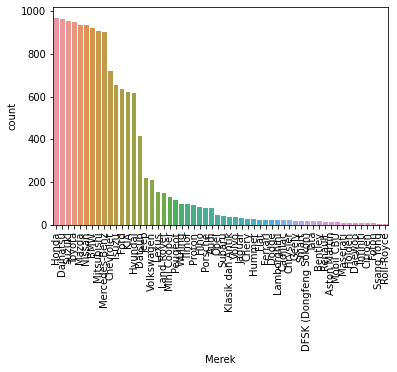

In [ ]:
#Plot the number of each 'Merek'
sns.countplot(x ='Merek', data = df1, order=df1['Merek'].value_counts().index)
plt.xticks(rotation=90) 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

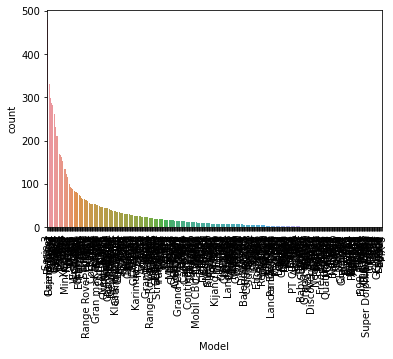

In [ ]:
#Plot the number of each 'Model' 
sns.countplot(x ='Model', data = df1, order=df1['Model'].value_counts().index) 
plt.xticks(rotation=90)

In [ ]:
df1.Varian.value_counts()

Lain-lain       2911
G                346
E                279
GX               252
GL               228
                ... 
QX80 5.6 AWD       1
SLK230K            1
1.7                1
300G               1
Luxury             1
Name: Varian, Length: 757, dtype: int64

In [ ]:
len(df1)

14142

In [ ]:
# Fill NaN values in Varian column by modus of corresponding model
from scipy import stats
from math import isnan

model_nan_filler = {}
model_set = set()

for item in df1['Model']:
    model_set.add(item)

for model in model_set:
    model_df = df1.loc[df1['Model'] == model]
    filler = stats.mode(model_df['Varian'])[0][0]
    
    model_nan_filler[model] = filler

for index, row in df1.iterrows():
    if row['Varian'] is np.nan:
        df1.at[index, 'Varian'] = model_nan_filler[row['Model']]

In [ ]:
# Drop 'Model' whose number less than 100
df2 = df1.groupby("Model").filter(lambda x: len(x) > 100)
print(len(df2))

6761


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

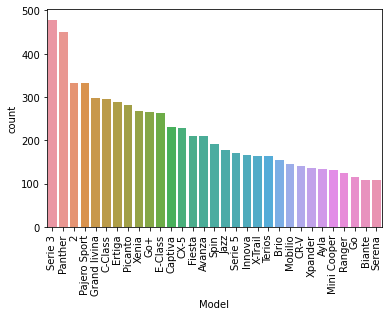

In [ ]:
#Plot the number of each 'Model'
sns.countplot(x ='Model', data = df2, order=df2['Model'].value_counts().index)
plt.xticks(rotation=90) 

In [ ]:
print(df2['Model'].value_counts())
print(len(df2['Model'].value_counts()))

Serie 3         478
Panther         449
2               333
Pajero Sport    332
Grand livina    298
C-Class         296
Ertiga          288
Picanto         282
Xenia           268
Go+             266
E-Class         262
Captiva         231
CX-5            229
Fiesta          210
Avanza          210
Spin            191
Jazz            177
Serie 5         170
Innova          167
X-Trail         164
Terios          163
Brio            154
Mobilio         145
CR-V            140
Xpander         136
Ayla            134
Mini Cooper     131
Ranger          124
Go              116
Biante          109
Serena          108
Name: Model, dtype: int64
31


In [ ]:
print(df2['Merek'].value_counts())
print(len(df2['Merek'].value_counts()))

Mazda            671
BMW              648
Honda            616
Nissan           570
Daihatsu         565
Mercedes-Benz    558
Mitsubishi       468
Isuzu            449
Chevrolet        422
Datsun           382
Toyota           377
Ford             319
Suzuki           288
KIA              282
Mini Cooper      131
Hino              15
Name: Merek, dtype: int64
16


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

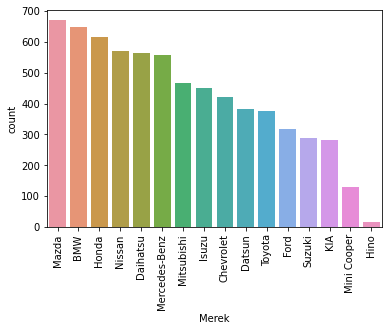

In [ ]:
#Plot the number of each 'Merek'
sns.countplot(x ='Merek', data = df2, order=df2['Merek'].value_counts().index)
plt.xticks(rotation=90) 

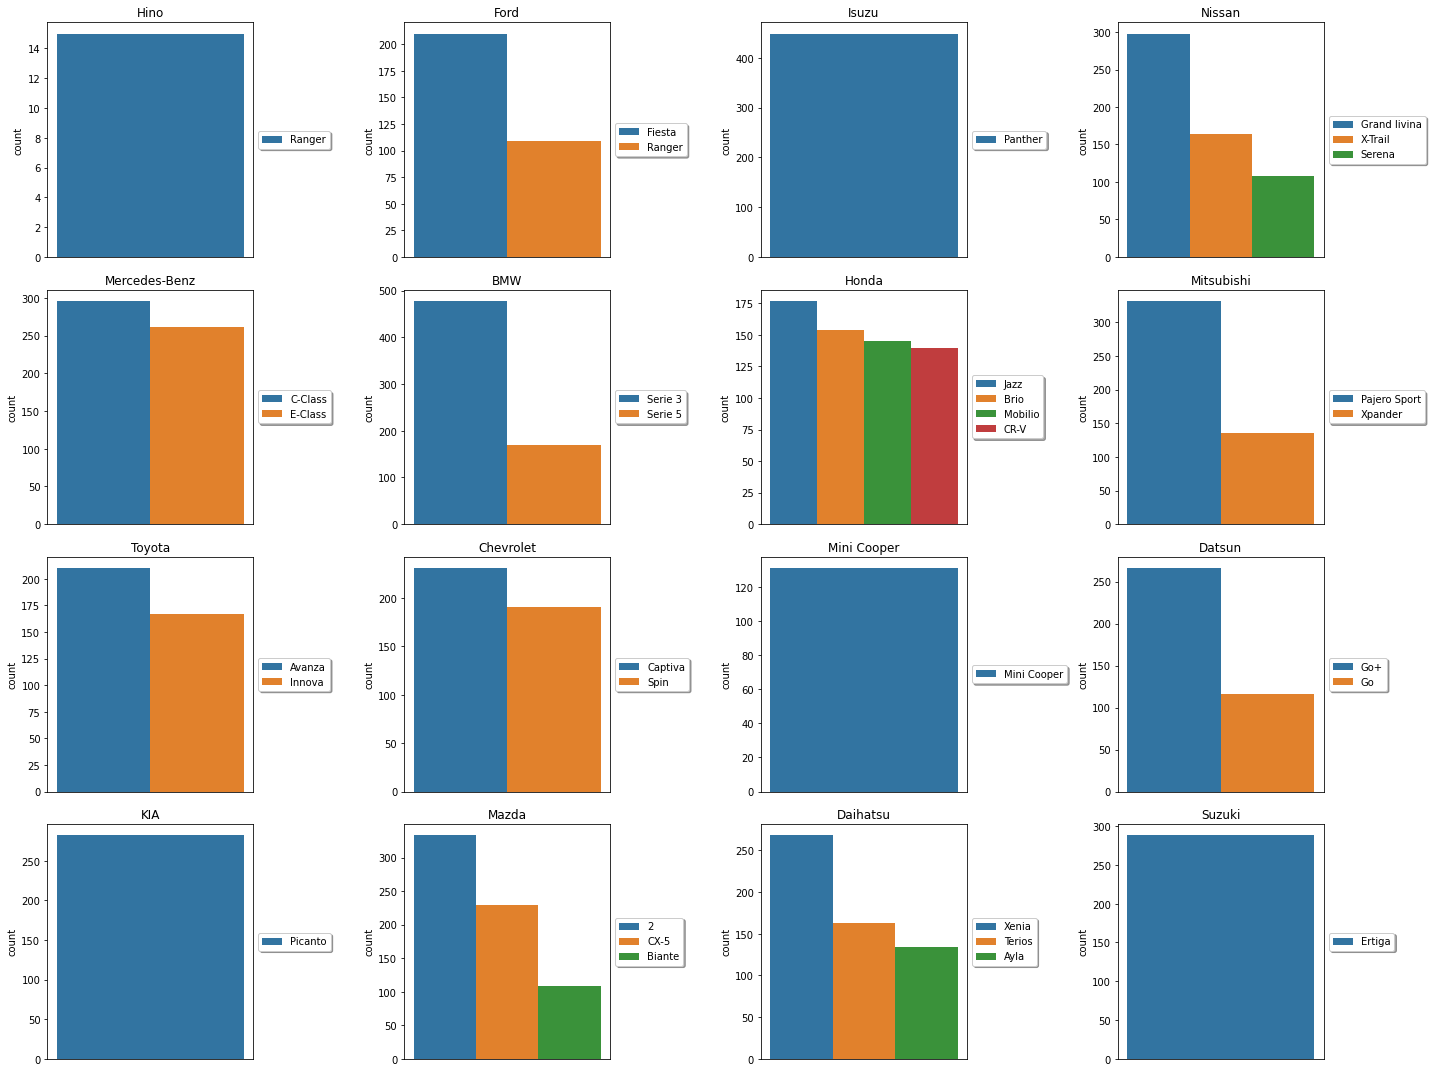

In [ ]:
#Plot the number of 'Model' for each 'Merek'
merek_set = set()

for item in df2['Merek']:
    merek_set.add(item)

fig, axes =plt.subplots(4,4, figsize=(20,15), sharex=True)
axes = axes.flatten()
for ax, merek in zip(axes, merek_set): 
    a = pd.Series(df2['Model'][df2['Merek'] == merek].tolist()) 
    sns.countplot(x=df2['Merek'][df2['Merek'] == merek].tolist(), data=df2, ax=ax, 
                  hue=df2['Model'][df2['Merek'] == merek].tolist(),
                  hue_order=a.value_counts().index).set(title=merek)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True) 
    
plt.xticks([])
plt.tight_layout() 
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


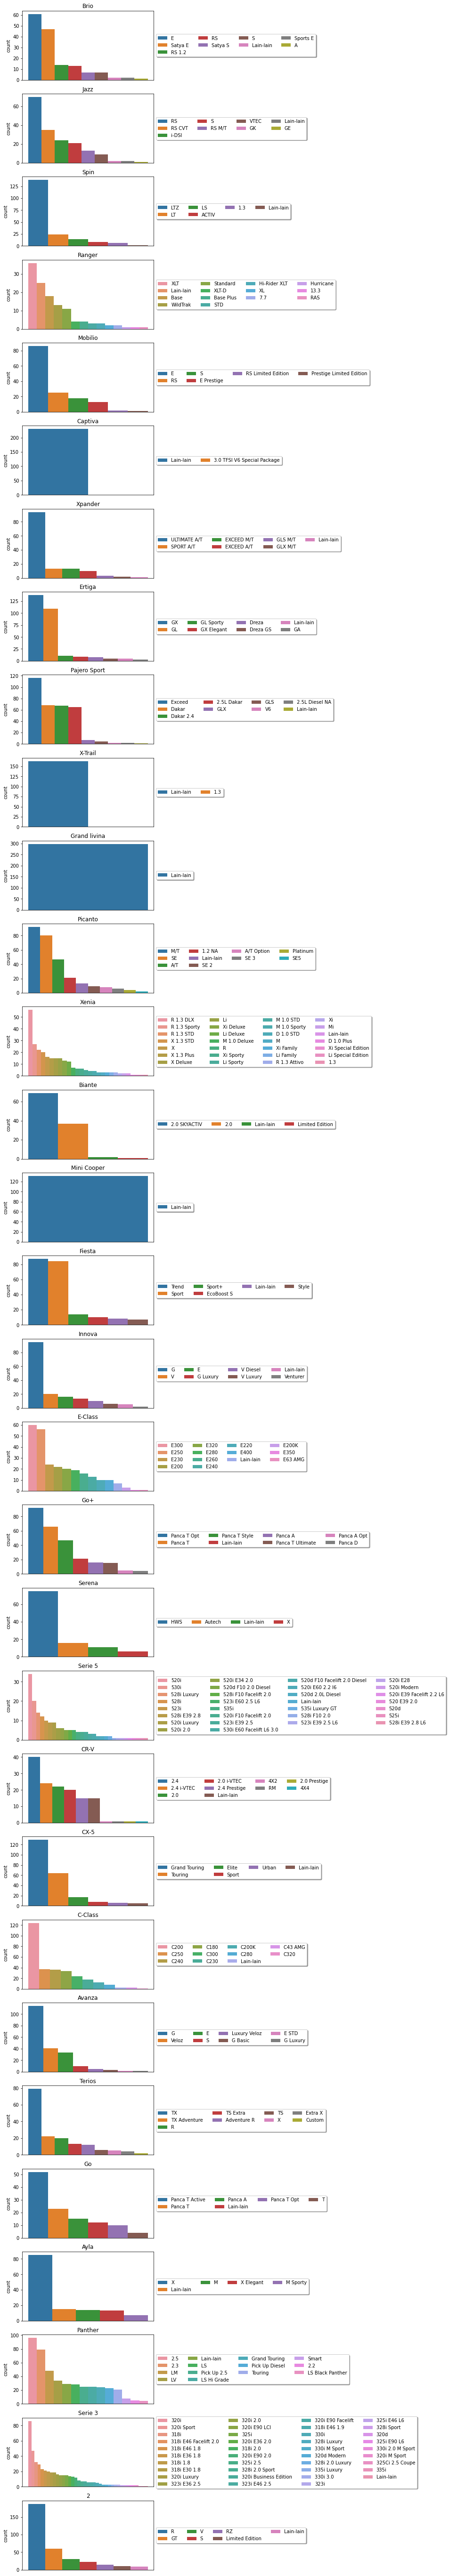

In [ ]:
#Plot the number of 'Varian' for each 'Model'
model_set = set()

for item in df2['Model']:
    model_set.add(item)

fig, axes =plt.subplots(31,1, figsize=(5,100), sharex=True)
axes = axes.flatten()
for ax, model in zip(axes, model_set):  
    a = pd.Series(df2['Varian'][df2['Model']==model].tolist()) 
    sns.countplot(x=df2['Model'][df2['Model']==model].tolist(), data=df2, ax=ax, 
                  hue=df2['Varian'][df2['Model']==model].tolist(),
                  hue_order=a.value_counts().index).set(title=model)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=4) 

plt.xticks([])
plt.tight_layout() 
plt.show()

From the plots above, we can see that many variants have very few data, so it will be difficult to predict the car price for certain variant. Therefore, I will not use the feature 'Varian' in the model training. I know that the prediction result may be not accurate due to the wide range of price for each model, but we can refine it later if more data have been collected.

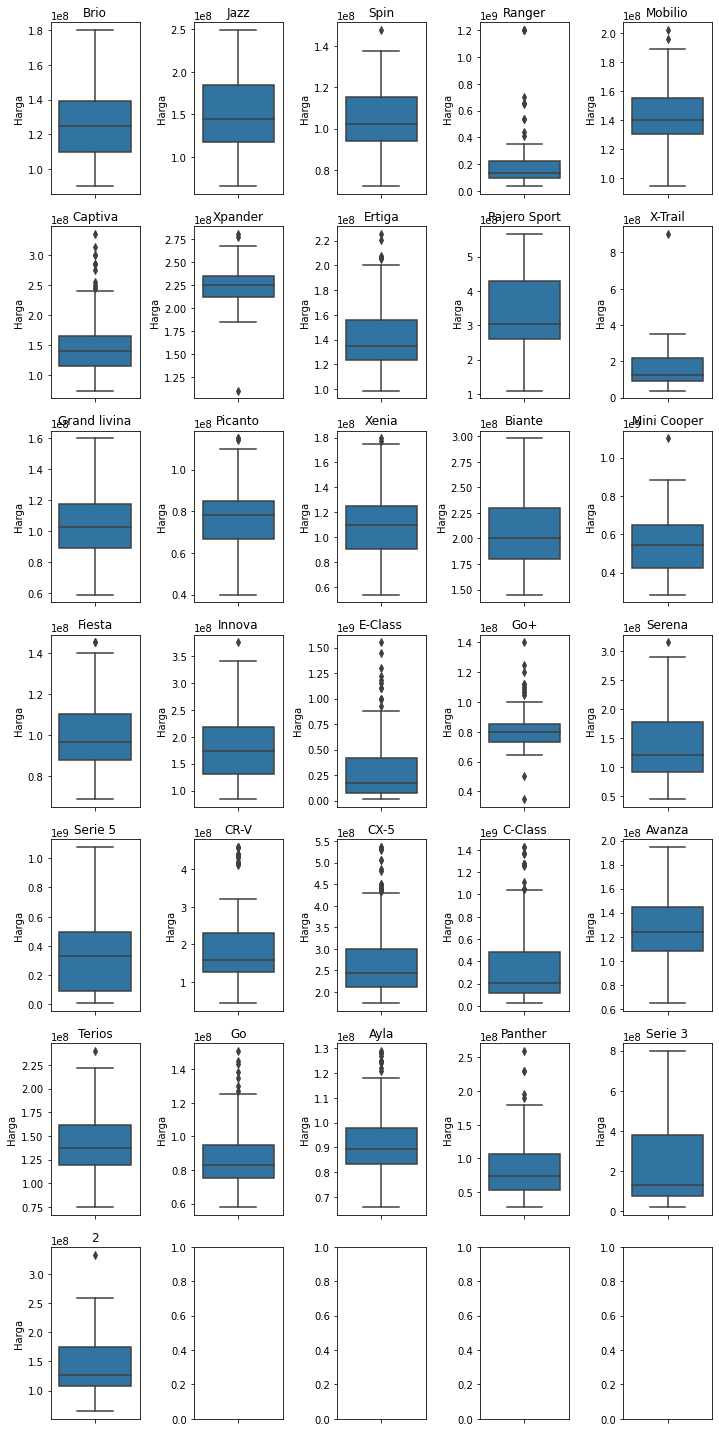

In [ ]:
#'Harga' Boxplot for each 'Model'
model_set = set()

for item in df2['Model']:
    model_set.add(item)

fig, axes =plt.subplots(7,5, figsize=(10,20), sharex=True)
axes = axes.flatten()
for ax, model in zip(axes, model_set):  
    sns.boxplot(y='Harga', data=df2[df2['Model']==model], showfliers=True, ax=ax).set(title=model)
    
plt.tight_layout() 
plt.show()

In [ ]:
# Drop outliers on 'Harga' grouped by 'Model'

outlier_params = {}
model_set = set()
indexes = []

for item in df2['Model']:
    model_set.add(item)

for model in model_set:
    model_df = df2.loc[df2['Model'] == model]
    param = [model_df['Harga'].mean(),
             model_df['Harga'].std() + 1]
    
    outlier_params[model] = param

for index, row in df2.iterrows():
    # Calculate Z-score then group index whose value >=3
    if (np.abs((row['Harga'] - outlier_params[row['Model']][0]) / outlier_params[row['Model']][1]) >= 3):
        indexes.append(index)

print(len(indexes))
df2 = df2.drop(index=indexes) # Remove rows with Z-score >=3

print(df2.shape)

38
(6723, 6)


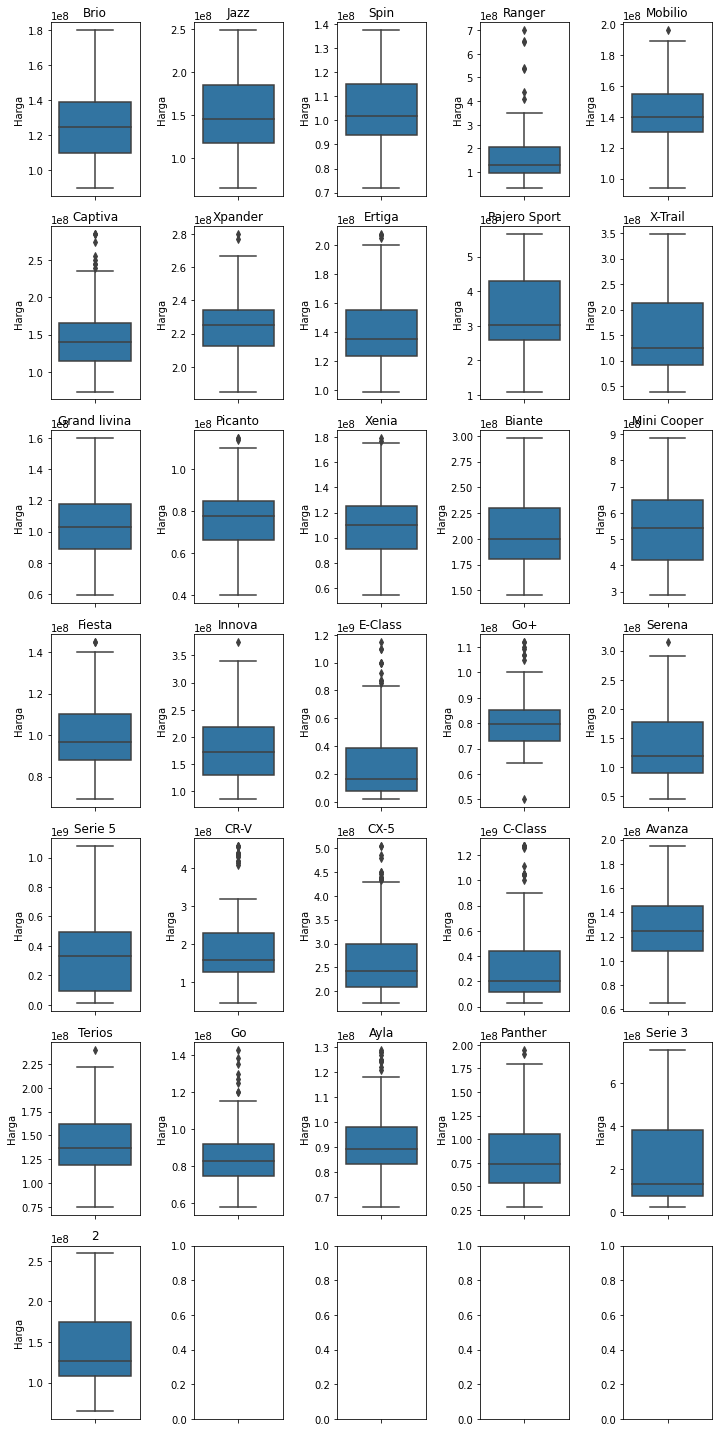

In [ ]:
#'Harga' Boxplot for each 'Model' after outliers removed
model_set = set()

for item in df2['Model']:
    model_set.add(item)

fig, axes =plt.subplots(7,5, figsize=(10,20), sharex=True)
axes = axes.flatten()
for ax, model in zip(axes, model_set):  
    sns.boxplot(y='Harga', data=df2[df2['Model']==model], showfliers=True, ax=ax).set(title=model)
    
plt.tight_layout() 
plt.show()

In [ ]:
# Drop rows with value 0 in columns 'Sistem Penggerak' and 'Tipe Penjual'
#indexes = []

#for index, row in df.iterrows():
#    if row['Sistem Penggerak'] == 0 or row['Tipe Penjual'] == 0:
#        indexes.append(index)
        
#print(indexes)
#df = df.drop(indexes)

#print(df.shape)

In [ ]:
# Scale the labels
scale_factor = 1000000

df2["Harga"] /= scale_factor 

# Shuffle the examples
df2 = df2.reindex(np.random.permutation(df2.index))

In [ ]:
from sklearn.preprocessing import minmax_scale

# Scaling column 'Jarak Tempuh'
df2['Jarak tempuh'] = minmax_scale(df2['Jarak tempuh'])

In [ ]:
# Set 1986 as minimum value in column 'Tahun'
df2['Tahun'].replace('<1986', 1986, inplace=True)

# Scaling column 'Tahun'
df2['Tahun'] = minmax_scale(df2['Tahun'])

In [ ]:
df2.head()

,Harga,Merek,Model,Varian,Tahun,Jarak tempuh
14177,110.0,Nissan,Grand livina,Lain-lain,0.787879,0.254237
12857,80.0,Isuzu,Panther,Pick Up 2.5,0.696970,0.677966
13042,155.0,Toyota,Avanza,Veloz,0.909091,0.050847
1009,47.0,Isuzu,Panther,2.3,0.242424,0.152542
4597,65.0,Datsun,Go+,Panca T,0.909091,0.203390


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6723 entries, 14177 to 1039
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Harga         6723 non-null   float64
 1   Merek         6723 non-null   object 
 2   Model         6723 non-null   object 
 3   Varian        6723 non-null   object 
 4   Tahun         6723 non-null   float64
 5   Jarak tempuh  6723 non-null   float64
dtypes: float64(3), object(3)
memory usage: 367.7+ KB


In [ ]:
# Rename dataframe columns
df2 = df2.rename(columns={"Merek": "merek", "Model": "model", "Tahun": "tahun", 
                        "Jarak tempuh": "jarak_tempuh", "Harga": "harga", "Varian":"varian"})

In [ ]:
# Drop column 'Varian'
df3 = df2.drop(['varian'], axis=1) 

#Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the dataframe into train and test
train, test = train_test_split(df3, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

5378 train examples
1345 test examples


In [ ]:
train.head()

,harga,merek,model,tahun,jarak_tempuh
11770,151.0,Honda,Mobilio,0.909091,0.135593
1893,180.0,Suzuki,Ertiga,0.969697,0.050847
11710,27.0,Mercedes-Benz,C-Class,0.272727,0.661017
7571,165.0,Suzuki,Ertiga,0.909091,0.084746
13510,650.0,Hino,Ranger,0.878788,0.288136


#Represent Data

In [ ]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent tahun.
tahun = tf.feature_column.numeric_column("tahun")
feature_columns.append(tahun)

# Create a numerical feature column to represent jarak tempuh.
jarak_tempuh = tf.feature_column.numeric_column("jarak_tempuh")
feature_columns.append(jarak_tempuh)

# Create a numerical feature column to represent kapasitas mesin.
#kapasitas_mesin = tf.feature_column.numeric_column("kapasitas_mesin")
#feature_columns.append(kapasitas_mesin)

In [ ]:
# Create a categorical feature column to represent merek.
merek = feature_column.categorical_column_with_vocabulary_list(
      'merek', df3['merek'].unique())
merek_one_hot = feature_column.indicator_column(merek)
feature_columns.append(merek_one_hot)

# Create a categorical feature column to represent model.
model = feature_column.categorical_column_with_vocabulary_list(
        'model', df3['model'].unique())
model_one_hot = feature_column.indicator_column(model)
feature_columns.append(model_one_hot)

# # Create a categorical feature column to represent tipe bahan bakar.
#tipebahanbakar = feature_column.categorical_column_with_vocabulary_list(
#                 'tipe_bahan_bakar', df['tipe_bahan_bakar'].unique())
#tipebahanbakar_one_hot = feature_column.indicator_column(tipebahanbakar)
#feature_columns.append(tipebahanbakar_one_hot)

# # Create a categorical feature column to represent warna.
#warna = feature_column.categorical_column_with_vocabulary_list(
#        'warna', df['warna'].unique())
#warna_one_hot = feature_column.indicator_column(warna)
#feature_columns.append(warna_one_hot)

# Create a categorical feature column to represent transmisi.
#transmisi = feature_column.categorical_column_with_vocabulary_list(
#            'transmisi', df['transmisi'].unique())
#transmisi_one_hot = feature_column.indicator_column(transmisi)
#feature_columns.append(transmisi_one_hot)

# # Create a categorical feature column to represent tipe penjual.
#tipepenjual = feature_column.categorical_column_with_vocabulary_list(
#              'tipe_penjual', df['tipe_penjual'].unique())
#tipepenjual_one_hot = feature_column.indicator_column(tipepenjual)
#feature_columns.append(tipepenjual_one_hot)

# Create a categorical feature column to represent sistem penggerak.
#sistempenggerak = feature_column.categorical_column_with_vocabulary_list(
#                  'sistem_penggerak', df['sistem_penggerak'].unique())
#sistempenggerak_one_hot = feature_column.indicator_column(sistempenggerak)
#feature_columns.append(sistempenggerak_one_hot)

# # Create a categorical feature column to represent kota/kab.
#kota = feature_column.categorical_column_with_vocabulary_list(
#       'kota', df['kota'].unique())
#kota_one_hot = feature_column.indicator_column(kota)
#feature_columns.append(kota_one_hot)

In [ ]:
feature_columns

[NumericColumn(key='tahun', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='jarak_tempuh', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='merek', vocabulary_list=('Nissan', 'Isuzu', 'Toyota', 'Datsun', 'Honda', 'Mazda', 'Chevrolet', 'BMW', 'Mercedes-Benz', 'Suzuki', 'Daihatsu', 'KIA', 'Ford', 'Mini Cooper', 'Mitsubishi', 'Hino'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='model', vocabulary_list=('Grand livina', 'Panther', 'Avanza', 'Go+', 'Jazz', '2', 'Spin', 'Serie 3', 'E-Class', 'Ertiga', 'Serie 5', 'Xenia', 'Picanto', 'C-Class', 'Fiesta', 'Ranger', 'Serena', 'Go', 'Mini Cooper', 'Pajero Sport', 'Brio', 'CX-5', 'X-Trail', 'Xpander', 'Terios', 'Captiva', 'Innova', 'Mobilio', 'Biante', 'CR-V', 'Ayla'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [ ]:
len(train)

5378

In [ ]:
# Split the dataset into features and label.
features = {name:np.array(value) for name, value in train.items()}
label = np.array(features.pop('harga'))

test_features = {name:np.array(value) for name, value in test.items()}
test_label = np.array(test_features.pop('harga')) 

#Linear Regression as a baseline

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.1
epochs = 300
batch_size = 30

In [ ]:
model = tf.keras.models.Sequential([
    # Convert the list of feature columns into a layer that will later be fed into the model.
    tf.keras.layers.DenseFeatures(feature_columns),
    # Define the output layer.
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
history = model.fit(features,
                    label,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1)

print("\n Evaluate the new model against the test set:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 

Epoch 1/300
180/180 [==============================] - 0s 1ms/step - loss: 144.7015 - mean_absolute_error: 144.7015
Epoch 2/300
180/180 [==============================] - 0s 1ms/step - loss: 96.0153 - mean_absolute_error: 96.0153
Epoch 3/300
180/180 [==============================] - 0s 1ms/step - loss: 79.4028 - mean_absolute_error: 79.4028
Epoch 4/300
180/180 [==============================] - 0s 1ms/step - loss: 72.4845 - mean_absolute_error: 72.4845
Epoch 5/300
180/180 [==============================] - 0s 1ms/step - loss: 67.2178 - mean_absolute_error: 67.2178
Epoch 6/300
180/180 [==============================] - 0s 1ms/step - loss: 63.5082 - mean_absolute_error: 63.5082
Epoch 7/300
180/180 [==============================] - 0s 1ms/step - loss: 61.0193 - mean_absolute_error: 61.0193
Epoch 8/300
180/180 [==============================] - 0s 1ms/step - loss: 59.0282 - mean_absolute_error: 59.0282
Epoch 9/300
180/180 [==============================] - 0s 1ms/step - loss: 57.3021 - m

[40.622928619384766, 40.622928619384766]

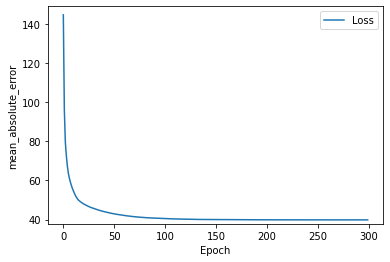

In [ ]:
# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# To track the progression of training, gather a snapshot
# of the model's mean squared error at each epoch. 
hist = pd.DataFrame(history.history)
mae = hist["mean_absolute_error"]

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("mean_absolute_error")

plt.plot(epochs, mae, label="Loss")
plt.legend()
plt.ylim([mae.min()*0.95, mae.max() * 1.03])
plt.show()  

#Deep Neural Network

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 200
batch_size = 30

In [ ]:
model = tf.keras.models.Sequential([
    # Convert the list of feature columns into a layer that will later be fed into the model.
    tf.keras.layers.DenseFeatures(feature_columns),
    # Define the first hidden layer with 256 nodes. 
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    # Define the second hidden layer with 256 nodes. 
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    # Define the third hidden layer with 256 nodes. 
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    # Define the output layer.
    tf.keras.layers.Dense(1, activation='linear')  
])

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
history = model.fit(features,
                    label,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1)

print("\n Evaluate the new model against the test set:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 

Epoch 1/200
180/180 [==============================] - 0s 3ms/step - loss: 94.6442 - mean_absolute_error: 83.4664
Epoch 2/200
180/180 [==============================] - 0s 3ms/step - loss: 51.4264 - mean_absolute_error: 42.8966
Epoch 3/200
180/180 [==============================] - 1s 3ms/step - loss: 44.2574 - mean_absolute_error: 35.8267
Epoch 4/200
180/180 [==============================] - 1s 3ms/step - loss: 39.9028 - mean_absolute_error: 31.2352
Epoch 5/200
180/180 [==============================] - 1s 3ms/step - loss: 37.9804 - mean_absolute_error: 29.5525
Epoch 6/200
180/180 [==============================] - 1s 3ms/step - loss: 36.7676 - mean_absolute_error: 28.7947
Epoch 7/200
180/180 [==============================] - 1s 3ms/step - loss: 35.6336 - mean_absolute_error: 27.9071
Epoch 8/200
180/180 [==============================] - 1s 3ms/step - loss: 34.8060 - mean_absolute_error: 27.4305
Epoch 9/200
180/180 [==============================] - 1s 3ms/step - loss: 34.0671 - mea

[23.405906677246094, 20.121267318725586]

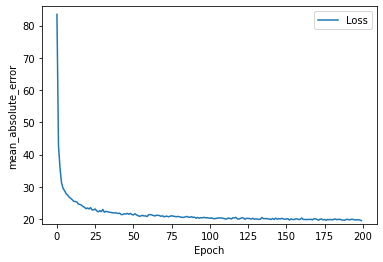

In [ ]:
# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# To track the progression of training, gather a snapshot
# of the model's mean squared error at each epoch. 
hist = pd.DataFrame(history.history)
mae = hist["mean_absolute_error"]

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("mean_absolute_error")

plt.plot(epochs, mae, label="Loss")
plt.legend()
plt.ylim([mae.min()*0.95, mae.max() * 1.03])
plt.show()  

#Feature Addition - Varian

## Split the dataset

In [ ]:
# Split the dataframe into train and test
train, test = train_test_split(df2, test_size=0.2)
print(len(train), 'train examples')
print(len(test), 'test examples')

5378 train examples
1345 test examples


In [ ]:
train.head()

,harga,merek,model,varian,tahun,jarak_tempuh
251,69.0,Mercedes-Benz,E-Class,E320,0.303030,0.406780
7397,67.5,KIA,Picanto,Lain-lain,0.727273,0.135593
11694,28.0,BMW,Serie 3,318i,0.212121,0.067797
11893,55.0,Mercedes-Benz,E-Class,E300,0.212121,0.677966
11983,650.0,Mini Cooper,Mini Cooper,Lain-lain,0.909091,0.050847


## Represent Data

In [ ]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent tahun.
tahun = tf.feature_column.numeric_column("tahun")
feature_columns.append(tahun)

# Create a numerical feature column to represent jarak tempuh.
jarak_tempuh = tf.feature_column.numeric_column("jarak_tempuh")
feature_columns.append(jarak_tempuh)

# Create a numerical feature column to represent kapasitas mesin.
#kapasitas_mesin = tf.feature_column.numeric_column("kapasitas_mesin")
#feature_columns.append(kapasitas_mesin)

In [ ]:
# Create a categorical feature column to represent merek.
merek = feature_column.categorical_column_with_vocabulary_list(
      'merek', df2['merek'].unique())
merek_one_hot = feature_column.indicator_column(merek)
feature_columns.append(merek_one_hot)

# Create a categorical feature column to represent model.
model = feature_column.categorical_column_with_vocabulary_list(
        'model', df2['model'].unique())
model_one_hot = feature_column.indicator_column(model)
feature_columns.append(model_one_hot)

# Create a categorical feature column to represent model.
model = feature_column.categorical_column_with_vocabulary_list(
        'varian', df2['varian'].unique())
model_one_hot = feature_column.indicator_column(model)
feature_columns.append(model_one_hot)
# # Create a categorical feature column to represent tipe bahan bakar.
#tipebahanbakar = feature_column.categorical_column_with_vocabulary_list(
#                 'tipe_bahan_bakar', df['tipe_bahan_bakar'].unique())
#tipebahanbakar_one_hot = feature_column.indicator_column(tipebahanbakar)
#feature_columns.append(tipebahanbakar_one_hot)

# # Create a categorical feature column to represent warna.
#warna = feature_column.categorical_column_with_vocabulary_list(
#        'warna', df['warna'].unique())
#warna_one_hot = feature_column.indicator_column(warna)
#feature_columns.append(warna_one_hot)

# Create a categorical feature column to represent transmisi.
#transmisi = feature_column.categorical_column_with_vocabulary_list(
#            'transmisi', df['transmisi'].unique())
#transmisi_one_hot = feature_column.indicator_column(transmisi)
#feature_columns.append(transmisi_one_hot)

# # Create a categorical feature column to represent tipe penjual.
#tipepenjual = feature_column.categorical_column_with_vocabulary_list(
#              'tipe_penjual', df['tipe_penjual'].unique())
#tipepenjual_one_hot = feature_column.indicator_column(tipepenjual)
#feature_columns.append(tipepenjual_one_hot)

# Create a categorical feature column to represent sistem penggerak.
#sistempenggerak = feature_column.categorical_column_with_vocabulary_list(
#                  'sistem_penggerak', df['sistem_penggerak'].unique())
#sistempenggerak_one_hot = feature_column.indicator_column(sistempenggerak)
#feature_columns.append(sistempenggerak_one_hot)

# # Create a categorical feature column to represent kota/kab.
#kota = feature_column.categorical_column_with_vocabulary_list(
#       'kota', df['kota'].unique())
#kota_one_hot = feature_column.indicator_column(kota)
#feature_columns.append(kota_one_hot)

In [ ]:
# Split the dataset into features and label.
features = {name:np.array(value) for name, value in train.items()}
label = np.array(features.pop('harga'))

test_features = {name:np.array(value) for name, value in test.items()}
test_label = np.array(test_features.pop('harga')) 

## Deep Neural Network

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 150
batch_size = 10

In [ ]:
model = tf.keras.models.Sequential([
    # Convert the list of feature columns into a layer that will later be fed into the model.
    tf.keras.layers.DenseFeatures(feature_columns),
    # Define the first hidden layer with 256 nodes. 
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    # Define the second hidden layer with 256 nodes. 
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    # Define the third hidden layer with 256 nodes. 
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.04)),
    # Define the output layer.
    tf.keras.layers.Dense(1)  
])

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [ ]:
history = model.fit(features,
                    label,
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    verbose=1)

print("\n Evaluate the new model against the test set:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 

Epoch 1/150
538/538 [==============================] - 2s 4ms/step - loss: 66.6328 - mean_absolute_error: 56.6165
Epoch 2/150
538/538 [==============================] - 2s 3ms/step - loss: 41.7116 - mean_absolute_error: 33.6267
Epoch 3/150
538/538 [==============================] - 2s 3ms/step - loss: 36.6996 - mean_absolute_error: 28.6619
Epoch 4/150
538/538 [==============================] - 2s 3ms/step - loss: 34.2593 - mean_absolute_error: 26.5553
Epoch 5/150
538/538 [==============================] - 2s 3ms/step - loss: 33.1264 - mean_absolute_error: 25.6090
Epoch 6/150
538/538 [==============================] - 2s 3ms/step - loss: 32.0661 - mean_absolute_error: 24.7734
Epoch 7/150
538/538 [==============================] - 2s 3ms/step - loss: 30.9132 - mean_absolute_error: 23.7049
Epoch 8/150
538/538 [==============================] - 2s 3ms/step - loss: 30.5972 - mean_absolute_error: 23.7521
Epoch 9/150
538/538 [==============================] - 2s 3ms/step - loss: 29.4943 - mea

[22.727968215942383, 19.51487922668457]

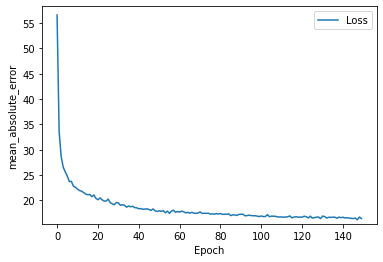

In [ ]:
# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# To track the progression of training, gather a snapshot
# of the model's mean squared error at each epoch. 
hist = pd.DataFrame(history.history)
mae = hist["mean_absolute_error"]

plt.figure()
plt.xlabel("Epoch")
plt.ylabel("mean_absolute_error")

plt.plot(epochs, mae, label="Loss")
plt.legend()
plt.ylim([mae.min()*0.95, mae.max() * 1.03])
plt.show()  